## Customer Purchase Predictor

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, f1_score, precision_recall_curve

In [2]:
data = pd.read_parquet("../data/processed/2019_oct_clean.parquet")

In [3]:
model = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=1000, random_state=42, C=1, class_weight="balanced")

In [4]:
print(data.columns)

Index(['event_time', 'event_type', 'user_id', 'user_purchase_count',
       'buyer_segment', 'clumpiness', 'month', 'weekday', 'hour_24', 'hour_12',
       'prev_event_time', 'hours_since_last_event', 'purchase_rate',
       'time_between_events', 'avg_clumpiness_purchase', 'event_counts',
       'avg_purchase_time', 'product_id', 'category', 'price', 'is_purchase'],
      dtype='object')


In [5]:
features_to_drop = ["event_time", "prev_event_time", "product_id", "user_id", "event_type", "hour_12"]
data = data.drop(features_to_drop, axis=1)

In [6]:
X = pd.get_dummies(data.drop(columns=["is_purchase"]), drop_first=True)
y = data["is_purchase"]

In [7]:
missing_count = X.isna().sum() > 0
missing_count = missing_count[missing_count > 0]
missing_count

hours_since_last_event    True
time_between_events       True
avg_purchase_time         True
dtype: bool

In [8]:
X["hours_since_last_event"] = X["hours_since_last_event"].fillna(X["hours_since_last_event"].median())
X["time_between_events"] = X["time_between_events"].fillna(X["time_between_events"].median())
X["avg_purchase_time"] = X["avg_purchase_time"].fillna(-1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42)

In [12]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:,1]

In [13]:
side_by_side = pd.DataFrame({
    "predicted" : y_pred,
    "actual": y_test
})
print(side_by_side)

         predicted  actual
862603           0       0
2662685          0       0
3618091          1       0
3546868          1       1
676664           0       0
...            ...     ...
3362763          1       0
471895           1       1
3566095          0       0
2743680          1       1
1665519          0       0

[986468 rows x 2 columns]


In [14]:
print(f"precision score: {precision_score(y_test, y_pred)}\
    \nrecall score: {recall_score(y_test, y_pred)}")


precision score: 0.46128783067780066    
recall score: 0.8478504200729085


In [15]:
y_pred_adjusted = (y_proba >= 0.56).astype(int)

In [16]:
print(f"precision score: {precision_score(y_test, y_pred_adjusted)}")
print(f"Recall score: {recall_score(y_test, y_pred_adjusted)}")


precision score: 0.488349003629577
Recall score: 0.7840664102820957


In [17]:
print(confusion_matrix(y_test, y_pred_adjusted))

[[568251 188614]
 [ 49579 180024]]


In [18]:
best_threshold = 0
best_f1 = 0

for t in np.arange(0.3, 0.7, 0.001):
    y_t = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_t) 
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
print(f"Best threshold: {best_threshold:.2f}")

Best threshold: 0.56


In [19]:
y_optimal_pred = (y_proba >= best_threshold).astype(int)
print(f"precision score: {precision_score(y_test, y_optimal_pred)}")
print(f"Recall score: {recall_score(y_test, y_optimal_pred)}")

precision score: 0.4865296717815959
Recall score: 0.7890619896081498


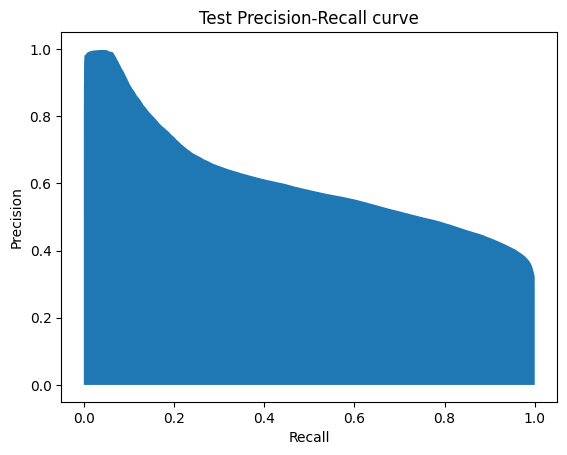

In [20]:
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve");

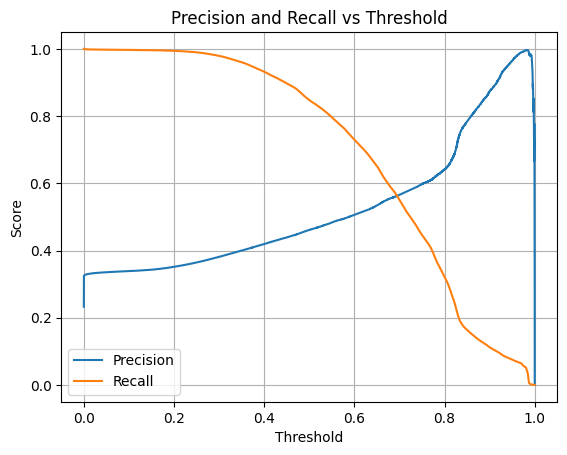

In [21]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
best_threshold = 0
for t in np.arange(0.6, 0.75, 0.01):
    idx = np.argmin(np.abs(thresholds - t))
    print(f"Threshold: {t:.2f} Precision: {precision[idx]:.2f} Recall: {recall[idx]:.2f}")

Threshold: 0.60 Precision: 0.51 Recall: 0.73
Threshold: 0.61 Precision: 0.51 Recall: 0.72
Threshold: 0.62 Precision: 0.52 Recall: 0.70
Threshold: 0.63 Precision: 0.52 Recall: 0.69
Threshold: 0.64 Precision: 0.53 Recall: 0.67
Threshold: 0.65 Precision: 0.53 Recall: 0.65
Threshold: 0.66 Precision: 0.54 Recall: 0.63
Threshold: 0.67 Precision: 0.55 Recall: 0.61
Threshold: 0.68 Precision: 0.56 Recall: 0.59
Threshold: 0.69 Precision: 0.56 Recall: 0.57
Threshold: 0.70 Precision: 0.57 Recall: 0.55
Threshold: 0.71 Precision: 0.57 Recall: 0.53
Threshold: 0.72 Precision: 0.58 Recall: 0.51
Threshold: 0.73 Precision: 0.58 Recall: 0.49
Threshold: 0.74 Precision: 0.59 Recall: 0.47
Threshold: 0.75 Precision: 0.60 Recall: 0.45


In [23]:
with open("../outputs/best_threshold.txt", "w") as thresh_file:
    thresh_file.write(str(0.67))

In [24]:
import joblib
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('model', LogisticRegression(
                         penalty="l2", 
                         solver="lbfgs", 
                         max_iter=1000, 
                         random_state=42, 
                         C=1, 
                         class_weight="balanced"))]
                    )
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [25]:
joblib.dump(pipeline, "../outputs/purchase_classifier_pipeline.joblib")

['../outputs/purchase_classifier_pipeline.joblib']

In [26]:
y_pred_final = (y_proba > 0.67).astype(int)

In [27]:
print(classification_report(y_test, y_pred_final))
print(confusion_matrix(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86    756865
           1       0.55      0.61      0.58    229603

    accuracy                           0.79    986468
   macro avg       0.71      0.73      0.72    986468
weighted avg       0.80      0.79      0.80    986468

[[642374 114491]
 [ 89960 139643]]


In [28]:
nov_data = pd.read_parquet("../data/processed/2019_Nov_clean.parquet")

In [29]:
features_to_drop = ["event_time", "prev_event_time", "product_id", "user_id", "event_type", "hour_12"]
nov_data = nov_data.drop(features_to_drop, axis=1)

In [30]:
nov_X = pd.get_dummies(data.drop(columns=["is_purchase"]), drop_first=True)
nov_y = data["is_purchase"]

In [ ]:
missing_count = nov_X.isna().sum() > 0
missing_count = missing_count[missing_count > 0]
print(missing_count.index)

Index(['hours_since_last_event', 'time_between_events', 'avg_purchase_time'], dtype='object')

In [32]:
nov_X["hours_since_last_event"] = nov_X["hours_since_last_event"].fillna(X["hours_since_last_event"].median())
nov_X["time_between_events"] = nov_X["time_between_events"].fillna(X["time_between_events"].median())
nov_X["avg_purchase_time"] = nov_X["avg_purchase_time"].fillna(-1)

In [33]:
nov_y_proba = pipeline.predict_proba(nov_X)[:,1]

In [34]:
nov_y_pred = (nov_y_proba > 0.67).astype(int)

In [35]:
print(classification_report(nov_y, nov_y_pred))
print(confusion_matrix(nov_y, nov_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86   3028930
           1       0.55      0.61      0.58    916939

    accuracy                           0.79   3945869
   macro avg       0.71      0.73      0.72   3945869
weighted avg       0.80      0.79      0.80   3945869

[[2572760  456170]
 [ 358914  558025]]


LinearExplainer explainer: 986469it [00:15, 21136.04it/s]                            


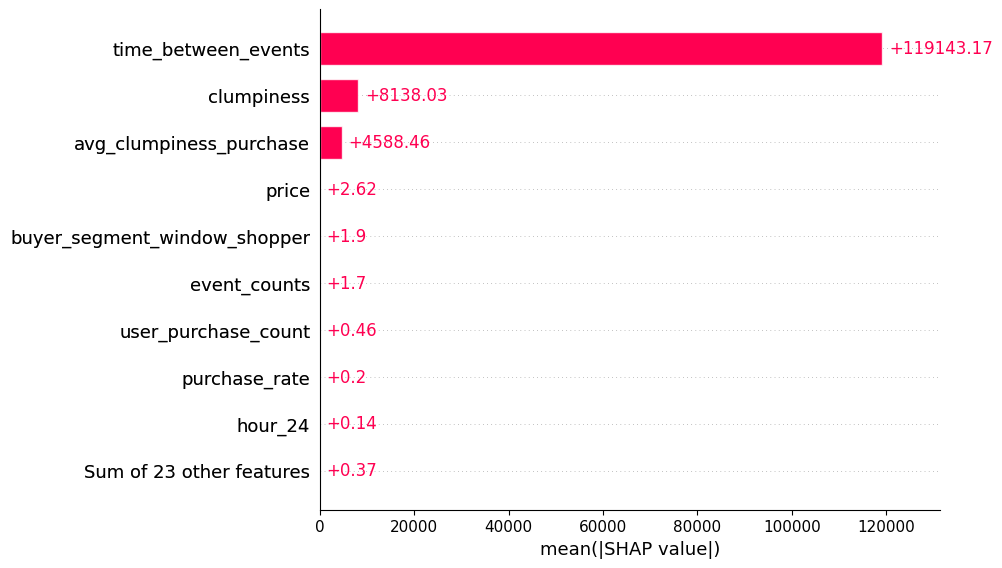

In [36]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)

In [ ]:
joblib.dump(shap_values, "../outputs/shap_values.joblib")

['shap_values.joblib']